In [1]:
import re
from tqdm import tqdm_notebook
from nltk.corpus import stopwords

In [2]:
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np

/home/ajay/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ajay/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ajay/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ajay/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

In [3]:
df = pd.read_csv('fake_or_real_news.csv')
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
Unnamed: 0    6335 non-null int64
title         6335 non-null object
text          6335 non-null object
label         6335 non-null object
dtypes: int64(1), object(3)
memory usage: 198.0+ KB


In [5]:
x = df['title'] + ' ' + df['text']
y = pd.get_dummies(df['label'])
y = np.array(y)

In [6]:
MAX_NB_WORDS = 100000 # max number of words for tokenizer
MAX_SEQUENCE_LENGTH = 1000 # max length of each sentences, including padding
VALIDATION_SPLIT = 0.2 # 20% of data for validation (not used in training)
EMBEDDING_DIM = 100 # embedding dimensions for word vectors
GLOVE_DIR = 'glove.6B.'+str(EMBEDDING_DIM)+'d.txt'

In [7]:
def clean_text(text, remove_stopwords = True):
    text = str(text).replace(r'http[\w:/\.]+','') # removing urls
    text = str(text).replace(r'[^\.\w\s]','') #remove everything but characters and punctuation 
    text = str(text).replace(r'\.\.+','.') #replace multiple periods with a single one 
    text = str(text).replace(r'\.',' . ') #replace periods with a single one
    text = str(text).replace(r'\s\s+',' ') #replace multiple white space with a single one 
    text = str(text).replace("\n", "") #removing line breaks
    text = re.sub(r'[^\w\s]','',text).lower() #lower texts 
    output=""
    if remove_stopwords:
        text = text.split(' ')
        for word in text:
            if word not in stopwords.words("english"):
                output = output + ' ' + word
    else:
        output = text
    return str(output.strip())[1:-3].replace(" ", " ")

In [8]:
texts =[]
for line in tqdm_notebook(x, total=df.shape[0]): 
    texts.append(clean_text(line))

In [9]:
print('Sample data:', texts[0], y[0])

Sample data: mell hillarys fear daniel greenfield shillman journalism fellow freedom center new york writer focusing radical islam final stretch election hillary rodham clinton gone war fbi word unprecedented thrown around often election ought retired still unprecedented nominee major political party go war fbi thats exactly hillary people done coma patients waking watching hour cnn hospital beds would assume fbi director james comey hillarys opponent election fbi attack everyone obama cnn hillarys people circulated letter attacking comey currently media hit pieces lambasting targeting trump wouldnt surprising clintons allies start running attack ads fbi fbis leadership warned entire leftwing establishment form lynch mob continue going hillary fbis credibility attacked media democrats preemptively head results investigation clinton foundation hillary clinton covert struggle fbi agents obamas doj people gone explosively public new york times compared comey j edgar hoover bizarre headlin

In [10]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 146511


In [11]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (6335, 1000)
Shape of label tensor: (6335, 2)


In [12]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [13]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [2516 2552]
validation:  [648 619]


In [14]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [ 2764  4215    52   209   862  3969  1194  1303    79  2833   197   278
  1222   225   444  2234    14  4215    52   209   862  3969  1194  1303
    79  2833   197   278  1222  1482  1003    50   883   265 87638 87639
   326   133  3567  2819 16085   512 12697   252 10726    12  6421   206
    24  4186 15135   360  1694  2236 33101  1761   217   206 13185  1806
 13185  1806   791  2763  5833   862   206  1855  3756  1643   721   961
   424  2459  1603   180   822  2763  5833   862   206  4147   176  1469
  5833  3092  3158 13185  1806   270   507   489  1398  2208     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

In [15]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding='utf8')
print('Loading Glove from:', GLOVE_DIR,'…', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix…", end="")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print("Completed..")

Loading Glove from: glove.6B.100d.txt …Done.
 Proceeding with Embedding Matrix…Completed..


In [16]:
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(Embedding(len(word_index) + 1,
 EMBEDDING_DIM,
 weights = [embedding_matrix],
 input_length = MAX_SEQUENCE_LENGTH,
 trainable=False,
 name = 'embedding'))
model.add(LSTM(60, return_sequences=True,name='lstm_layer'))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(2, activation="sigmoid"))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
history = model.fit(x_train, y_train, epochs = 10, batch_size=128, validation_data=(x_val, y_val))

Train on 5068 samples, validate on 1267 samples
Epoch 1/10
5068/5068 [==============================] - 180s 35ms/sample - loss: 0.6372 - acc: 0.6345 - val_loss: 0.5286 - val_acc: 0.7431
Epoch 2/10
5068/5068 [==============================] - 57s 11ms/sample - loss: 0.4642 - acc: 0.7882 - val_loss: 0.3994 - val_acc: 0.8307
Epoch 3/10
5068/5068 [==============================] - 56s 11ms/sample - loss: 0.3737 - acc: 0.8353 - val_loss: 0.3292 - val_acc: 0.8666
Epoch 4/10
5068/5068 [==============================] - 56s 11ms/sample - loss: 0.3084 - acc: 0.8717 - val_loss: 0.3214 - val_acc: 0.8552
Epoch 5/10
5068/5068 [==============================] - 56s 11ms/sample - loss: 0.2712 - acc: 0.8913 - val_loss: 0.2761 - val_acc: 0.8879
Epoch 6/10
5068/5068 [==============================] - 56s 11ms/sample - loss: 0.2344 - acc: 0.9036 - val_loss: 0.2605 - val_acc: 0.8970
Epoch 7/10
5068/5068 [==============================] - 57s 11ms/sample - loss: 0.2089 - acc: 0.9156 - val_loss: 0.2389 - v

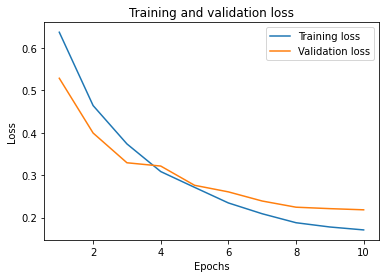

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

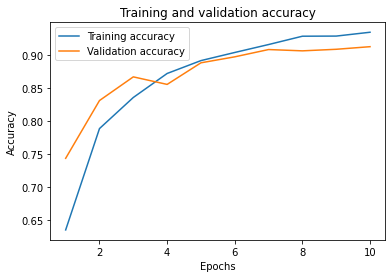

In [27]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

#### As we can see both our train and validation scores are good. Now let’s test our model with some random data from our dataset.

In [30]:
random_num = np.random.randint(0, 100)
test_data = x[random_num]
test_label = y[random_num]
clean_test_data = clean_text(test_data)
test_tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
test_tokenizer.fit_on_texts(clean_test_data)
test_sequences = tokenizer.texts_to_sequences(clean_test_data)
word_index = test_tokenizer.word_index
test_data_padded = pad_sequences(test_sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [31]:
prediction = model.predict(test_data_padded)

In [32]:
prediction[random_num].argsort()[-len(prediction[random_num]):]

array([1, 0])

In [33]:
test_label

array([1, 0], dtype=uint8)

In [37]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [46]:
from tensorflow.keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Loaded model from disk


In [47]:
another_prediction=loaded_model.predict(test_data_padded)

In [48]:
another_prediction[random_num].argsort()[-len(another_prediction[random_num]):]

array([1, 0])